### Import Libraries


In [ ]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


fer2013 image dataset from Kaggle  

In [ ]:
fer2013_path = "/content/drive/My Drive/Colab Notebooks/Advanced_AI/project/facial_emotion_detection/fer2013.csv"

In [ ]:
# get the data
emotions_list = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df=pd.read_csv(fer2013_path, na_filter=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
df.pixels[0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [ ]:
df = df.drop('Usage', axis=1)

Plotting Gray Scale Images

In [ ]:
df_demo_imgs = df.copy()
df_demo_imgs.pixels = df['pixels'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(48, 48))
df_head = df_demo_imgs.head(10)

In [ ]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for pixel in df_head.pixels:
        ctr += 1
        plt.subplot(7,5,ctr)
        img = pixel
        plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

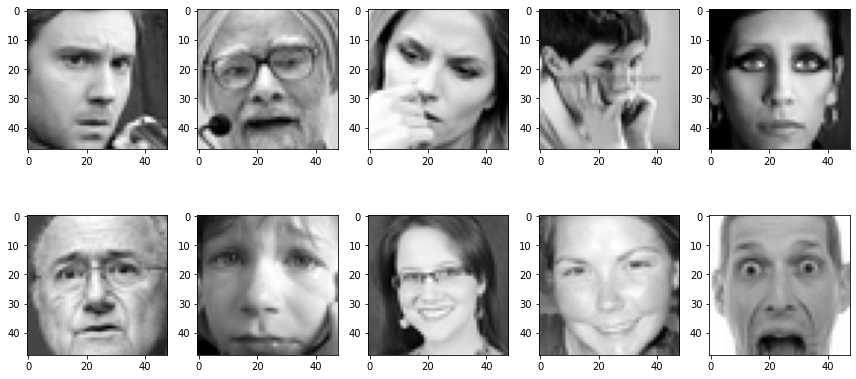

In [ ]:
plot_example_images(plt)

In [ ]:
Pixel = []
emotion = []
getPixel = lambda x: Pixel.append([int(p) for p in x.split()])
getEmotion = lambda y: emotion.append(int(y))

In [ ]:
_y=df.pixels.apply(getPixel)
_x=df.emotion.apply(getEmotion)

### Normalisation, Scaling and Transformation

In [ ]:
X, Y = np.array(Pixel) / 255.0, np.array(emotion)

In [ ]:
count_distinct_emotions = len(set(Y))
print(count_distinct_emotions)

7


In [ ]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1) #scaling images

### Defining Model

In [ ]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Training model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train = (np.arange(count_distinct_emotions) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(count_distinct_emotions) == y_test[:, None]).astype(np.float32)

In [ ]:
from tensorflow.keras import backend as K

path_model='model_filter.h5' # save model at this location after each epoch
K.clear_session() # destroys the current graph and builds a new one
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model

history=model.fit(
    x=X_train,
    y=y_train,
    batch_size=100,
    epochs=14,
    verbose=1,
    validation_data=(X_test,y_test),
    shuffle=True,
    callbacks=[
        ModelCheckpoint(filepath=path_model),
    ]
)

Epoch 1/14
288/288 [==============================] - 15s 43ms/step - loss: 1.9395 - accuracy: 0.2568 - val_loss: 1.9141 - val_accuracy: 0.2023
Epoch 2/14
288/288 [==============================] - 12s 41ms/step - loss: 1.4768 - accuracy: 0.4302 - val_loss: 1.5714 - val_accuracy: 0.4037
Epoch 3/14
288/288 [==============================] - 12s 41ms/step - loss: 1.2883 - accuracy: 0.5024 - val_loss: 1.3577 - val_accuracy: 0.4999
Epoch 4/14
288/288 [==============================] - 12s 41ms/step - loss: 1.1864 - accuracy: 0.5532 - val_loss: 1.2368 - val_accuracy: 0.5306
Epoch 5/14
288/288 [==============================] - 12s 41ms/step - loss: 1.1160 - accuracy: 0.5755 - val_loss: 1.3820 - val_accuracy: 0.4719
Epoch 6/14
288/288 [==============================] - 12s 41ms/step - loss: 1.0570 - accuracy: 0.5980 - val_loss: 1.2577 - val_accuracy: 0.5273
Epoch 7/14
288/288 [==============================] - 12s 41ms/step - loss: 1.0127 - accuracy: 0.6171 - val_loss: 1.0847 - val_accuracy:

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

225/225 [==============================] - 1s 6ms/step - loss: 1.0843 - accuracy: 0.6077
Accuracy: 60.77


In [ ]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

Training accuracy: 0.739315
Validation accuracy: 0.607690


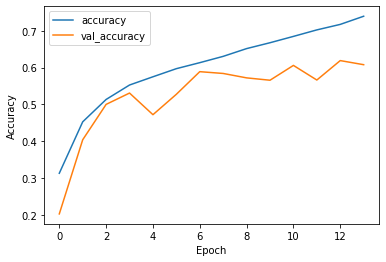

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % history.history['accuracy'][-1])
print('Validation accuracy: %f' % history.history['val_accuracy'][-1])

In [ ]:
#print("Accuracy =%f"%(accuracy_score(y_test, y_pred)*100))

In [ ]:
 y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

(7178, 7)

In [ ]:
print("Accuracy =%f"%(mean_squared_error(y_test, y_pred, squared=False)*100))

Accuracy =27.243671


In [ ]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

plt.show()

In [ ]:
#print("Accuracy =%f"%(accuracy_score(y_test,y_pred)*100))

In [ ]:
img1 = '/content/drive/My Drive/Colab Notebooks/Advanced_AI/project/facial_emotion_detection/images/peter-idowu-hxvw9aqrKS4-unsplash.jpg'
img2 = '/content/drive/My Drive/Colab Notebooks/Advanced_AI/project/facial_emotion_detection/images/alexander-krivitskiy-TD9rSZywT7Y-unsplash.jpg'

Real Time Emotion Detection

In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [ ]:
MODEL =load_model("/content/drive/MyDrive/Datasets/model_filter.h5")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


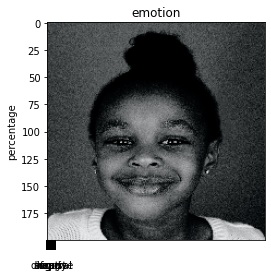

Emotion Prediction: neutral


In [ ]:
from skimage import io
from keras.preprocessing import image
img = load_img(img1, grayscale=True, target_size=(48, 48))
show_img= load_img(img1, target_size=(200, 200))
x = img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = MODEL.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Emotion Prediction:',objects[ind])

In [ ]:
import cv2

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


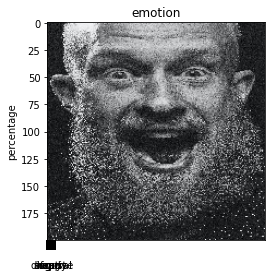

Emotion Prediction: angry


In [ ]:
img = image.load_img(img2, grayscale=True, target_size=(48, 48))
show_img=image.load_img(img2, grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Emotion Prediction:',objects[ind])